# Hands-On NLP - Class 2: Sparse Representations & Traditional ML

**Goal:** Transform text into numerical vectors and build text classifiers.

## Notebook Outline

| Part | Topic | Description |
|------|-------|-------------|
| **1** | Loading the Dataset | Load StackExchange texts from 6 categories |
| **2** | Manual Vectorization | Build intuition by counting keywords by hand |
| **3** | Sklearn Vectorization | Use `CountVectorizer` and `TfidfVectorizer` |
| **4** | Classification | Train Naive Bayes on TF-IDF features |
| **5** | Evaluation & Error Analysis | Confusion matrices, classification reports |
| **6** | Comparing Classifiers | NB vs Logistic Regression vs SVM |
| **7** | N-gram Experiments | Unigrams vs bigrams vs combined |
| **8** | Feature Importance | Which words predict each category? + Word Clouds |
| **9** | Hyperparameter Tuning | Effect of `max_features`, `min_df`, and regularization |
| **10** | Cross-Validation | Robust evaluation with k-fold CV |

**Key Concepts:**
- Bag of Words (BoW) and TF-IDF representations
- Sparse matrix representations for text
- Multi-class classification with traditional ML
- Model comparison and hyperparameter exploration
- Cross-validation for reliable performance estimates

你的这个作业（Class 2: Sparse Representations & Traditional ML）主要是让你**用传统机器学习方法做文本分类**，具体步骤如下：

### 主要任务流程
1. **加载数据集**  
   读取 StackExchange 的 6 个类别文本数据。

2. **手动特征工程**  
   选定关键词，统计每篇文档中这些词出现的次数，理解“文本转数字”的过程。

3. **自动特征工程（Sklearn）**  
   用 `CountVectorizer` 和 `TfidfVectorizer` 把文本转成稀疏向量（BoW、TF-IDF）。

4. **分类模型训练**  
   用 TF-IDF 特征训练 Naive Bayes 分类器。

5. **模型评估与错误分析**  
   输出分类报告、混淆矩阵，分析模型表现和错误。

6. **对比不同分类器**  
   比较 Naive Bayes、Logistic Regression、SVM 的效果。

7. **N-gram 实验**  
   比较只用单词（unigram）、加上词组（bigram）等不同特征的效果。

8. **特征重要性分析**  
   找出哪些词对每个类别最有预测力，并用词云可视化。

9. **超参数调优**  
   试验不同的 `max_features`、`min_df`、正则化参数等，观察对结果的影响。

10. **交叉验证**  
    用 k-fold cross-validation 得到更可靠的模型评估。

### 你需要做的
- 按照每一部分的 `🚧 TODO` 补全代码和分析。
- 理解每一步的原理和意义，写出简短的解释或观察。
- 最后总结你的发现和经验。

如果你需要某一部分的详细解释或代码补全，可以告诉我！

In [1]:
import collections
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Sklearn imports
from sklearn import decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

try:
    from wordcloud import WordCloud
except ImportError:
    print("⚠️ wordcloud not installed. Run: pip install wordcloud")
# Setup
tqdm.pandas()
sns.set_style("darkgrid")
sns.set_context("notebook")
pd.set_option("display.precision", 3)

## Part 1: Loading the Dataset

> ⚠️ **Important:** This notebook requires the `texts/` folder containing the StackExchange dataset.  
> Make sure to place this notebook **in the same folder as Notebook 1**, where you extracted the `texts/` folder.  
> If you see a "file not found" error, check that the folder structure looks like:
> ```
> your_folder/
> ├── 2026-new-HoNLP-notebook-1-....ipynb
> ├── 2026-new-HoNLP-notebook-2-....ipynb  ← this notebook
> └── texts/
>     ├── health/
>     ├── mythology/
>     └── ...
> ```

In [2]:
# StackExchange Dataset
# We load the texts from the 'texts' folder as in previous weeks
DATA_DIR = Path("texts")
CORPORA = ["mythology", "woodworking", "robotics", "hsm", "health", "portuguese"]

data = []
# Load data into a list of dictionaries
# Iterate over corpora, read files, append to data list

# Solution:
for cat_id, corpus in enumerate(tqdm(CORPORA)):
    corpus_path = DATA_DIR / corpus
    if not corpus_path.exists():
        continue
    for text_file in corpus_path.glob("*.txt"):
        with open(text_file, "r") as f:
            text = f.read()
        data.append({
            "text": text,
            "category": corpus,
            "cat_id": cat_id
        })

print(f"Loaded {len(data)} documents.")

100%|██████████| 6/6 [00:01<00:00,  3.25it/s]

Loaded 52683 documents.


In [3]:
df = pd.DataFrame(data)
# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,text,category,cat_id
0,Q:\n\nHow does a variable speed control mechan...,woodworking,1
1,Q:\n\nMultiple files in one add_executable\n\n...,robotics,2
2,Q:\n\nadd sources for rosinstall\n\nI am tryin...,robotics,2
3,Q:\n\nunable to install ros on ubuntu 12.04\n\...,robotics,2
4,Q:\n\nO que é a crase?\n\nVendo esta pergunta ...,portuguese,5


Documents per category:
category
robotics       39674
health          3733
hsm             2887
woodworking     2860
portuguese      2026
mythology       1503
Name: count, dtype: int64

Total documents: 52683
Average text length: 2813 characters


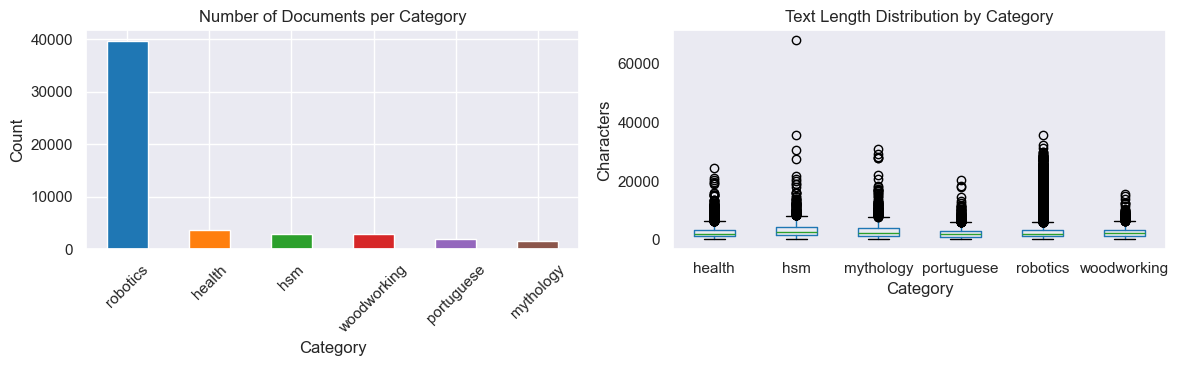

In [4]:
# Dataset Overview: How balanced is our corpus?
# 打印每个类别的文档数量、总文档数、平均文本长度（字符数）
print("Documents per category:")
print(df["category"].value_counts())
print(f"\nTotal documents: {len(df)}")
print(f"Average text length: {df['text'].str.len().mean():.0f} characters")

# Add text length column for visualization
# 文档长度（字符数）
df["text_len"] = df["text"].str.len()

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart of document counts
# 在左侧子图画出每个类别的文档数量条形图，横轴为类别，纵轴为数量。
df["category"].value_counts().plot(kind="bar", ax=axes[0], color=plt.cm.tab10.colors[:6])
axes[0].set_title("Number of Documents per Category")
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# 🚧 TODO: Box plot of text lengths by category
# 在右侧子图画出每个类别的文本长度分布箱线图（boxplot），可以直观比较不同类别的文本长度差异。
df.boxplot(column="text_len", by="category", ax=axes[1], grid=False)
axes[1].set_title("Text Length Distribution by Category")
axes[1].set_xlabel("Category")
axes[1].set_ylabel("Characters")
plt.suptitle("")  # Remove automatic title

plt.tight_layout()
plt.show()

### ⚠️ Dataset Imbalance Alert!

**Our dataset is heavily imbalanced:** Robotics has ~40,000 documents while other categories have only ~1,000-3,000 each!

**Why this matters:**
- A model predicting "robotics" for everything would get ~80% accuracy!
- **Accuracy can be misleading** when classes are imbalanced

**Better metrics for imbalanced data:**
- **Macro F1-score** — Average F1 across classes (treats all classes equally)
- **Per-class Precision/Recall** — See performance on minority classes
- **Confusion Matrix** — Visualize where errors occur

👉 **Best practice:** Always check the classification report's F1-scores, not just accuracy! In this notebook, our models perform so well (~98-99%) that accuracy and Macro F1 are very close — but for harder tasks or worse models, the gap can be huge.

这段话的意思是：

你的数据集类别分布极度不均衡（比如robotics有4万条，其他类别只有1千到3千条）。如果模型只学会“无脑”预测所有文本都是robotics，准确率也能达到约80%，但这其实没有任何实际意义。

**为什么要注意？**
- 只看准确率会被“多数类”误导，模型可能完全不会识别少数类别，但准确率依然很高。
- 这对实际应用是灾难性的，比如医疗文本分类时，少数类（罕见疾病）才是最重要的。

**更好的评估方法：**
- **Macro F1-score**：对每个类别分别算F1分数再平均，所有类别权重相同，能真实反映模型对小类别的能力。
- **每类的Precision/Recall**：可以看到模型对每个类别的具体表现，尤其是少数类。
- **混淆矩阵**：直观展示模型把哪些类别搞混了。

**最佳实践：**
- 不要只看accuracy，要看F1-score和混淆矩阵，尤其关注小类别的表现。
- 在本notebook里，由于模型效果很好，accuracy和Macro F1很接近。但在更难的任务或模型较差时，两者差距会很大。

**一句话总结：**
数据不平衡时，准确率不能反映真实效果，要用Macro F1等更公平的指标！

**F1和混淆矩阵怎么看？举例说明：**

---

**F1分数：**
- F1分数是精确率（Precision）和召回率（Recall）的调和平均，综合反映模型“查得准”和“查得全”的能力。
- 反映模型对每个类别的“查准率”和“查全率”的综合表现。
- 例如：某类别有100个真实样本，模型只预测对了60个，F1分数就不会高，说明模型对这个类别识别能力弱。
- **Macro F1**是所有类别F1的平均值，能公平反映模型对小类别的表现。

**混淆矩阵：**
- 行代表真实类别，列代表预测类别。
- 例如：真实类别A有100个，模型预测对了80个A，错分成B有20个，则A行A列是80，A行B列是20。
- 主对角线数字越大越好，非对角线数字大说明模型容易混淆这两个类别。

**例子：**
假设有3类：A、B、C，混淆矩阵如下：

|      | 预测A | 预测B | 预测C |
|------|-------|-------|-------|
| 真A  |  80   |  15   |   5   |
| 真B  |   8   |  90   |   2   |
| 真C  |   3   |   7   |  90   |

- 真A被预测成A有80个，错分成B有15个，错分成C有5个。
- 你可以看到模型最容易把A错分成B。

**结论：**
- 看F1分数关注小类别表现，混淆矩阵看模型容易混淆哪些类别。

## Part 2: From Strings to Numbers (Intuition)

Before using powerful libraries, let's build a vectorizer "by hand" to understand what's happening.

We will pick a few keywords and count their occurrence in each document.

**🚧 TODO:** Create a DataFrame where each column is a keyword count for each document.

In [6]:
# 🚧 TODO: Count keyword occurrences in each document
# 计算每个文档中手动指定关键词的出现次数，构建一个新的DataFrame，行对应文档，列对应关键词，值为出现次数。
# Small vocabulary of interest
manual_keywords = "myth,wood,robot,history,science,mathematics,health,portuguese".split(",")

# Solution:
# Create a DataFrame of counts
wc_df = pd.DataFrame(index=df.index)
for w in manual_keywords:
    # Case insensitive count? For simplicity, we stick to data as is or simple lower().
    # Let's check how many times each keyword appears in each text
    wc_df[w] = df["text"].str.lower().str.count(w.lower())

print("Manual Bag of Words (First 5 docs):")
print(wc_df.head(25))

# Add the labels back for visualization
wc_df["label"] = df["category"]

Manual Bag of Words (First 5 docs):
    myth  wood  robot  history  science  mathematics  health  portuguese
0      0     0      0        0        0            0       0           0
1      0     0      0        0        0            0       0           0
2      0     0      0        0        0            0       0           0
3      0     0      0        0        0            0       0           0
4      0     0      0        0        0            0       0           0
5      0     0      0        0        0            0       0           0
6      0     5      0        0        0            0       0           0
7      0     0      0        0        0            1       0           0
8      0     0      0        0        0            0       0           0
9      0     0      3        0        0            0       0           0
10     0     0      0        0        0            0       0           0
11     0     0     12        0        0            0       0           0
12     0     0 

### 2.1 Visualizing High-Dimensional Data (PCA)

Our `wc_df` has 8 dimensions (one for each keyword). We can't see 8D!

**What is PCA?**  
PCA (Principal Component Analysis) finds the directions of maximum variance in your data and projects it onto fewer dimensions.

🎯 **Intuition:** Imagine shining a flashlight on a 3D object and looking at its 2D shadow on the wall. PCA finds the best angle to shine the light so the shadow preserves as much shape information as possible.

```
8D data (8 keyword counts)
    │
    ▼  PCA
2D data (PC1, PC2) ──► Can plot on screen!
```

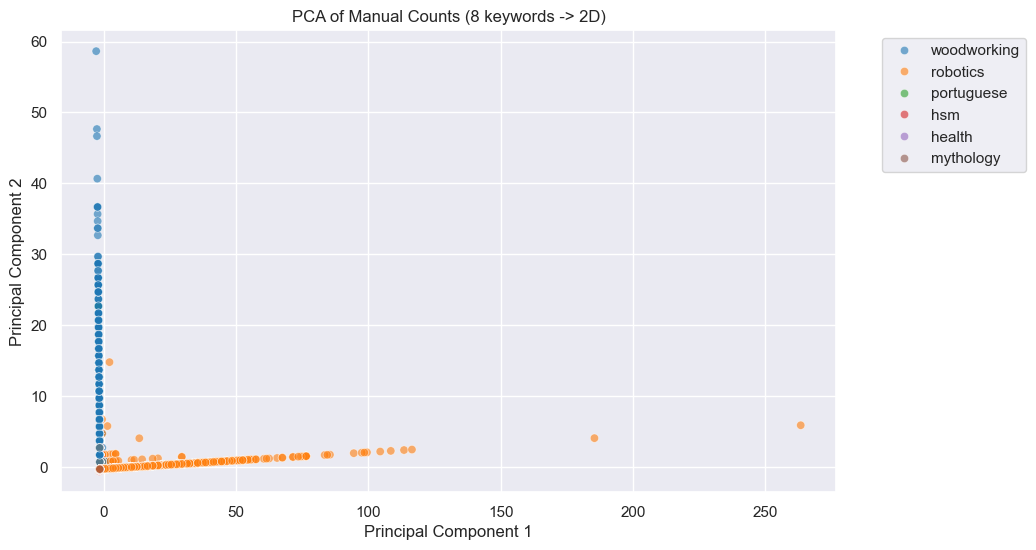

In [8]:
# Drop label for PCA
X_manual_pca = wc_df.drop(columns=["label"])
y_manual_pca = wc_df["label"]

# 🚧 TODO: Simple PCA to 2 components
pca = decomposition.PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_manual_pca)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=y_manual_pca, alpha=0.6, palette="tab10")
plt.title("PCA of Manual Counts (8 keywords -> 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 🤔 Why do only Robotics and Woodworking stand out?

Look at the PCA plot above: **robotics** (orange, spread along PC1) and **woodworking** (blue, spread along PC2) are clearly separated, but all other categories are clustered at the origin!

### 🚧 TODO: Find the reason. Explain what you've learned.
**The reason:** 

... your explanation here ...

**Key insight:** 

... your insight here ...

**Lesson:** Manual feature selection is brittle! This is why we need **automatic vectorization** (CountVectorizer, TF-IDF) that considers ALL words in the corpus.

The reason:
只有Robotics和Woodworking在PCA图中明显分开，是因为我们手动选的8个关键词（如robot, wood等）只有“robot”高度相关于Robotics，“wood”高度相关于Woodworking。这两个类别的文档会频繁出现各自的专属关键词，而其他类别（如mythology、health等）在这些关键词上的计数几乎都是0，因此在降维后都被压缩在原点附近，无法区分。

Key insight:
手动挑选的关键词只能区分那些与关键词强相关的类别，无法覆盖所有类别的特征。这样做会导致特征空间极度稀疏，大部分类别的信息丢失，模型无法有效区分它们。

Lesson:
手动特征选择很脆弱且容易遗漏关键信息。实际NLP任务中，应该用自动化方法（如CountVectorizer、TF-IDF）提取全量词汇特征，才能全面反映文本差异，提高模型表现。

## Part 3: Professional Vectorization (Sklearn)

Counting by hand is slow and misses thousands of words.
We use `scikit-learn` for efficient Bag of Words (BoW) & TF-IDF.

### 3.1 CountVectorizer (Bag of Words)

**How it works:**

```
Document: "the robot builds robots"
            ↓
Vocabulary: [builds, robot, robots, the]
            ↓
Vector:     [  1,      1,      1,     1  ]  (counts)
```

Each document becomes a **sparse vector** of word counts.  
"Sparse" = mostly zeros (a document uses only ~100 words out of 50,000 vocabulary).

**🚧 TODO:**
Use `CountVectorizer` to turn the text into a document-term matrix.
Limit to `max_features=5000` to keep it manageable.

这一段代码的作用是：
用 CountVectorizer 把所有文本转化为“词袋”特征矩阵（即文档-词频矩阵），并限制只保留最常见的5000个词（max_features=5000），同时去除英文停用词（stop_words="english"）。

具体解释如下：

vectorizer = CountVectorizer(max_features=5000, stop_words="english")
初始化一个CountVectorizer对象，设置最多只保留5000个高频词，并自动去除常见英文停用词（如the, is等无实际意义的词）。

X_bow = vectorizer.fit_transform(df["text"])
用fit_transform方法对所有文本进行分词、统计词频，生成稀疏的文档-词频矩阵（每行是一个文档，每列是一个词，值为该词在该文档中出现的次数）。

print(f"Shape of BoW matrix: {X_bow.shape}")
打印生成的矩阵形状，比如(52683, 5000)，表示有52683个文档，每个文档用5000维的词频向量表示。

print(f"Feature names (first 10): {vectorizer.get_feature_names_out()[:10]}")
打印前10个特征词（即词表中的前10个词）。

In [ ]:
# 🚧 TODO: Initialize and fit CountVectorizer
vectorizer = CountVectorizer(max_features=5000, stop_words="english")
X_bow = vectorizer.fit_transform(df["text"])

print(f"Shape of BoW matrix: {X_bow.shape}")
print(f"Feature names (first 10): {vectorizer.get_feature_names_out()[:10]}")

Shape of BoW matrix: (52683, 5000)
Feature names (first 10): ['00' '000' '0000' '000000' '0001' '001' '002' '003' '005' '01']


In [10]:
# Let's peek inside the sparse matrix!
# Sparse matrices store only non-zero values (memory efficient)

print("Type:", type(X_bow))
print("Stored as sparse matrix with only", X_bow.nnz, "non-zero values")
print(f"If dense: {X_bow.shape[0] * X_bow.shape[1]:,} values ({X_bow.shape[0]}×{X_bow.shape[1]})")
print(f"Sparsity: {100 * (1 - X_bow.nnz / (X_bow.shape[0] * X_bow.shape[1])):.1f}% zeros\n")

# Show a tiny slice as a dense array
print("First 3 documents, first 10 words:")
print("Words:", vectorizer.get_feature_names_out()[:10])
print(X_bow[:3, :10].toarray())

Type: <class 'scipy.sparse._csr.csr_matrix'>
Stored as sparse matrix with only 5405161 non-zero values
If dense: 263,415,000 values (52683×5000)
Sparsity: 97.9% zeros

First 3 documents, first 10 words:
Words: ['00' '000' '0000' '000000' '0001' '001' '002' '003' '005' '01']
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


### 3.2 TF-IDF (Term Frequency - Inverse Document Frequency)

Words that appear everywhere (like "the", "is") are less informative.
TF-IDF downweights common words and upweights distinctive ones.

**The Formula:**
$$ \text{TF-IDF}(t, d) = \text{TF}(t, d) \times \log\left(\frac{N}{\text{DF}(t)}\right) $$

**Concrete Example:**

| Term | Doc1 Count (TF) | Appears in N docs (DF) | Total docs (N) | IDF = log(N/DF) | TF-IDF |
|------|-----------------|------------------------|----------------|-----------------|--------|
| "the" | 10 | 1000 | 1000 | log(1) = 0 | 10 × 0 = **0** |
| "robot" | 5 | 50 | 1000 | log(20) ≈ 3 | 5 × 3 = **15** |
| "arduino" | 2 | 10 | 1000 | log(100) ≈ 4.6 | 2 × 4.6 = **9.2** |

🎯 **Key insight:** "the" appears everywhere → IDF ≈ 0 → TF-IDF ≈ 0 (ignored!)  
   Rare domain words get high scores.

**🚧 TODO:** Use `TfidfVectorizer` instead of `CountVectorizer`.

In [11]:
# 🚧 TODO: Initialize and fit TfidfVectorizer
tfidf_vec = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf_vec.fit_transform(df["text"])

print(f"Shape of TF-IDF matrix: {X_tfidf.shape}") 
# should be something like 
# Shape of TF-IDF matrix: (52683, 5000)

Shape of TF-IDF matrix: (52683, 5000)


### 3.3 Visualizing TF-IDF Features with PCA

Let's visualize our high-dimensional TF-IDF features in 2D using **Principal Component Analysis (PCA)**.

**What is PCA?**
- Reduces dimensions while preserving variance
- Projects data onto orthogonal axes that capture maximum variance
- Helps visualize high-dimensional data

We'll reduce from 5000 dimensions to 2 dimensions for plotting.

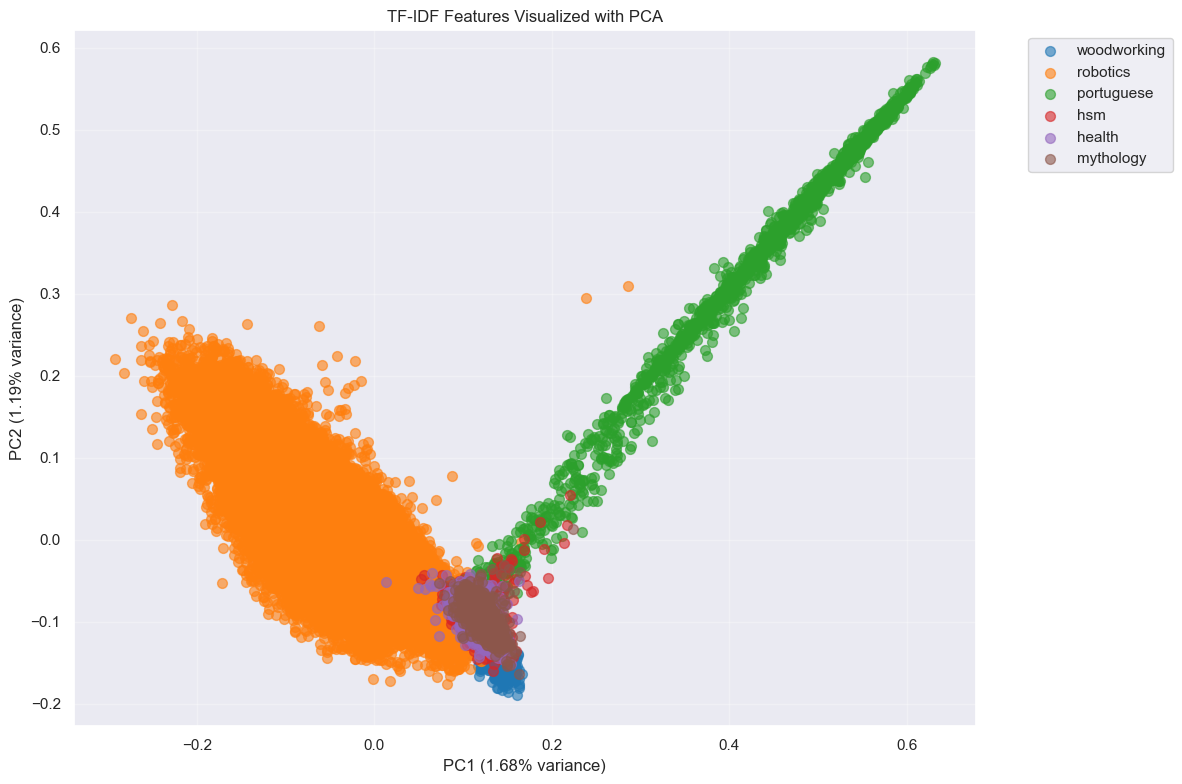

Total variance explained by 2 components: 2.86%


In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 🚧 TODO: Apply PCA to reduce to 2 dimensions
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Create scatter plot colored by category
plt.figure(figsize=(12, 8))
categories = df["category"].unique()
colors = plt.cm.tab10(range(len(categories)))

for i, category in enumerate(categories):
    mask = df["category"] == category
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=[colors[i]], label=category, alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('TF-IDF Features Visualized with PCA')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total variance explained by 2 components: {sum(pca.explained_variance_ratio_):.2%}")

### 🔍 Observations from the TF-IDF PCA Plot

**What stands out:**

1. **Portuguese is highly distinctive** — The green cluster forms a clear diagonal line, completely separated from all other categories. This makes sense: Portuguese texts use an entirely different language vocabulary!

2. **Robotics forms its own cluster** — The orange cluster spreads widely on the left side, indicating robotics has distinctive technical vocabulary (sensors, motors, Arduino, etc.)

3. **Other categories overlap** — Woodworking, health, hsm (history of science/math), and mythology are clustered together near the center. Their vocabularies share more common English words.

4. **Low variance explained (~3%)** — This is typical for text data! TF-IDF produces very high-dimensional sparse vectors where variance is spread across thousands of dimensions. PCA captures only a small fraction, yet the clustering is still visible.

**Key insight:** Even with just 2 components explaining ~3% of variance, we can already see category structure. This suggests TF-IDF features will work well for classification!

Remaining documents: 10983 (removed robotics and portuguese)
Categories: ['woodworking' 'hsm' 'health' 'mythology']


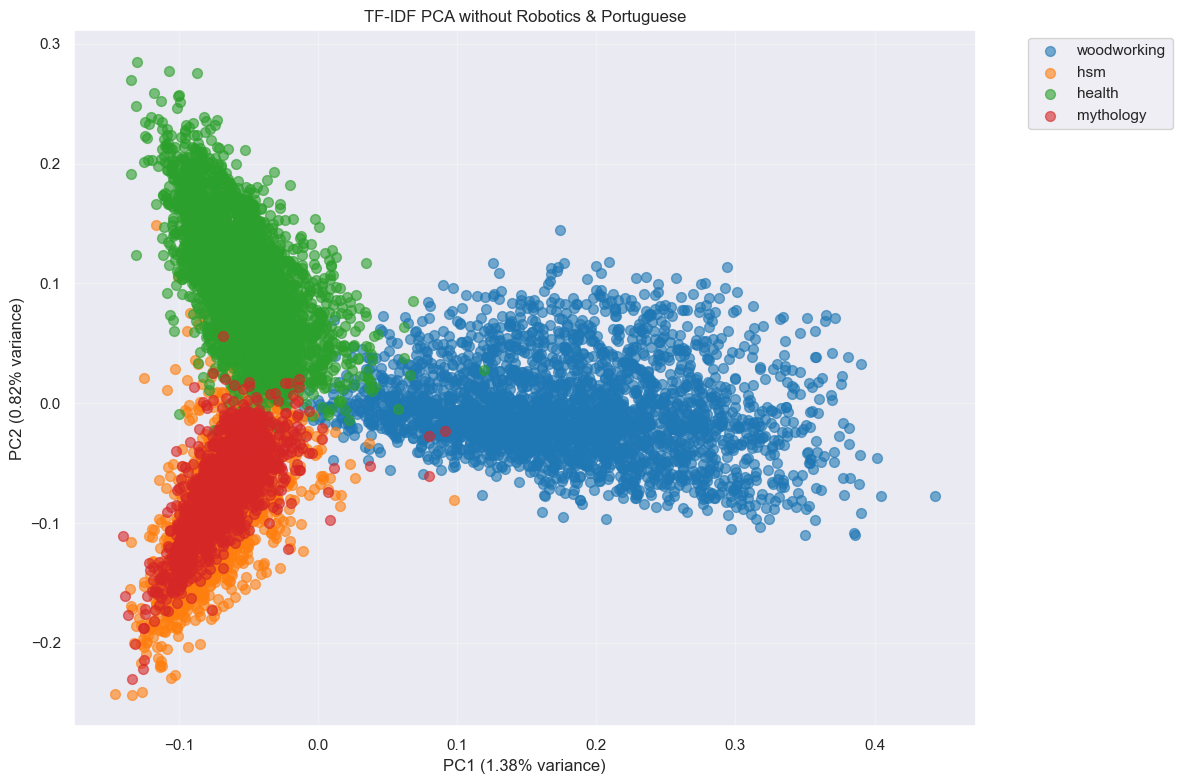

Total variance explained by 2 components: 2.20%


In [14]:
# Remove robotics and portuguese to see if remaining categories are separable
df_subset = df[~df["category"].isin(["robotics", "portuguese"])].copy()
print(f"Remaining documents: {len(df_subset)} (removed robotics and portuguese)")
print(f"Categories: {df_subset['category'].unique()}")

# 🚧 TODO: Re-fit TF-IDF on the subset
tfidf_subset = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf_subset = tfidf_subset.fit_transform(df_subset["text"])

# Apply PCA
pca_subset = decomposition.PCA(n_components=2)
X_pca_subset = pca_subset.fit_transform(X_tfidf_subset.toarray())

# Plot
plt.figure(figsize=(12, 8))
categories_subset = df_subset["category"].unique()
colors_subset = plt.cm.tab10(range(len(categories_subset)))

for i, category in enumerate(categories_subset):
    mask = df_subset["category"] == category
    plt.scatter(X_pca_subset[mask, 0], X_pca_subset[mask, 1], 
                c=[colors_subset[i]], label=category, alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca_subset.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_subset.explained_variance_ratio_[1]:.2%} variance)')
plt.title('TF-IDF PCA without Robotics & Portuguese')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total variance explained by 2 components: {sum(pca_subset.explained_variance_ratio_):.2%}")

### 🔍 Observations after Removing Outlier Categories

### 🚧 TODO: 

**What changed:**
... your observations here ...


**Key insight:** Removing "easy" categories ... your insight here ...

What changed:
去除“robotics”和“portuguese”这两个最容易区分的类别后，剩下的类别（woodworking、health、hsm、mythology）在PCA二维空间中的分布明显变得更加重叠，聚集在中心区域，类别之间的边界变得模糊，难以像之前那样清晰分开。这说明这些类别在词汇层面有较多重叠，缺乏高度区分性的专有词。

Key insight:
移除“容易”的类别后，剩余类别的区分难度大大增加，PCA可视化中类别结构不再明显。这说明在实际文本分类任务中，容易区分的类别会掩盖模型在“难分”类别上的表现。只有在去除这些“显著特征”类别后，才能真正检验特征和模型的区分能力。因此，评估模型时要关注难分类别的表现，不能只看整体准确率。

## Part 4: Classification

Now we use our TF-IDF vectors to train a classifier!

**Multinomial Naive Bayes:**  
A simple, fast classifier that works well for text. It assumes:
- Words are independent (the "naive" assumption)
- Word counts follow a multinomial distribution

```
Training: Learn P(word | category) from labeled examples
Prediction: P(category | document) ∝ P(category) × ∏ P(word | category)
```

**🚧 TODO:**
1. Split data into Train/Test (80/20)
2. Train the model on TF-IDF features
3. Evaluate on held-out test set

In [16]:
y = df["cat_id"]

# 🚧 TODO: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# 🚧 TODO: Train Model
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
print("Model trained.")

Model trained.


## Part 5: Evaluation & Error Analysis

**Key Metrics:**
- **Precision:** Of all predicted "mythology", how many were actually mythology?
- **Recall:** Of all actual mythology texts, how many did we find?
- **F1-Score:** Harmonic mean of precision & recall (balanced measure)

**Confusion Matrix:** Shows where the model gets confused.
```
                 Predicted
              myth  wood  robot
Actual myth   [45]   2     3     ← 45 correct, 5 confused with others
       wood    1   [38]    1
       robot   0     2   [42]
```

In [17]:
# 🚧 TODO: Print classification report
print(classification_report(y_test, y_pred, target_names=CORPORA))

# ⚠️ IMPORTANT: With imbalanced data, focus on:
# - Macro avg F1: treats all classes equally (not weighted by support)
# - Per-class F1: check performance on minority classes (mythology, woodworking, etc.)
# - Don't be fooled by high accuracy — it's inflated by the robotics majority class!

              precision    recall  f1-score   support

   mythology       0.98      0.97      0.97       301
 woodworking       0.93      0.99      0.96       572
    robotics       1.00      0.99      0.99      7935
         hsm       0.90      0.97      0.93       577
      health       0.96      0.98      0.97       747
  portuguese       1.00      0.96      0.98       405

    accuracy                           0.99     10537
   macro avg       0.96      0.98      0.97     10537
weighted avg       0.99      0.99      0.99     10537



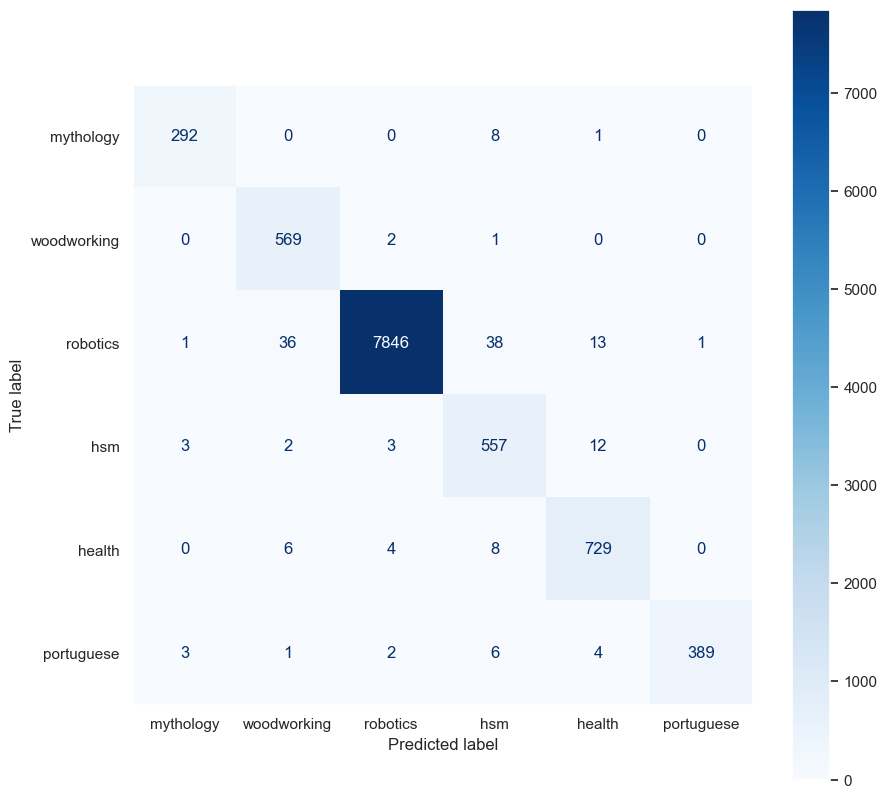

In [18]:
# 🚧 TODO: Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CORPORA)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues")
plt.grid(False)
plt.show()

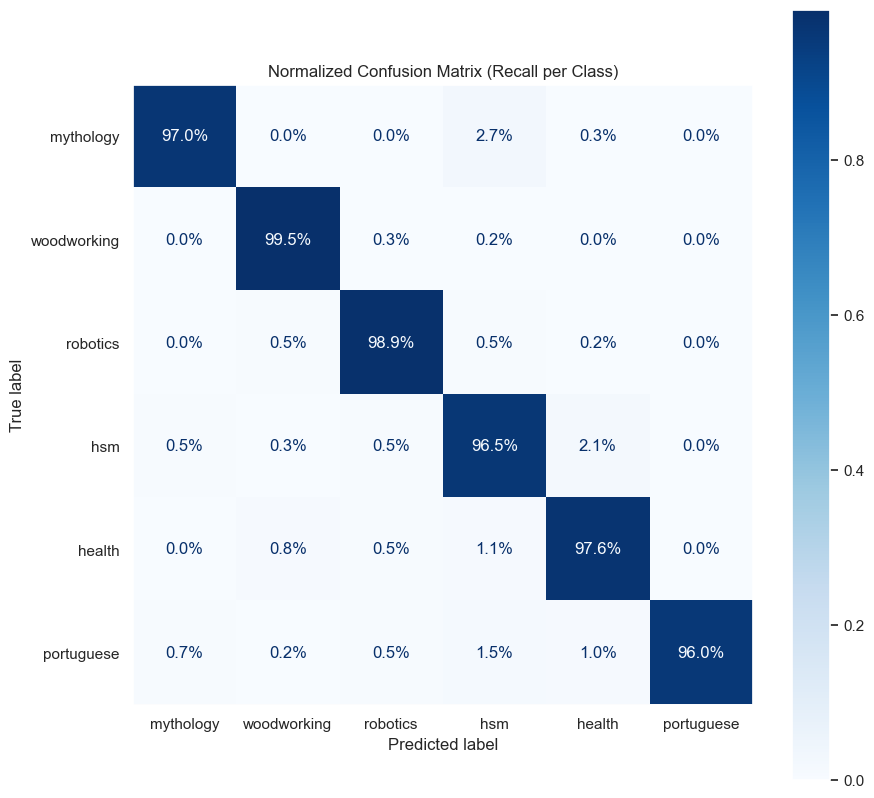

Each row sums to 100% (or 1.0)
Diagonal = Recall (sensitivity) for each class
Off-diagonal = where errors go for each true class


In [19]:
# Normalized Confusion Matrix (percentages per true class)
# This shows RECALL for each class: what % of actual category X were correctly predicted?
# Useful when corpus sizes are imbalanced!

cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')  # normalize by row (true labels)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=CORPORA)

fig, ax = plt.subplots(figsize=(10, 10))
disp_norm.plot(ax=ax, cmap="Blues", values_format=".1%")
plt.title("Normalized Confusion Matrix (Recall per Class)")
plt.grid(False)
plt.show()

print("Each row sums to 100% (or 1.0)")
print("Diagonal = Recall (sensitivity) for each class")
print("Off-diagonal = where errors go for each true class")

In [21]:
# 🔍 Error Analysis: Let's find where the model fails

# First, let's see overall accuracy
accuracy = (y_pred == y_test).mean()
print(f"Overall Accuracy: {accuracy:.1%}")
print(f"⚠️  Remember: accuracy is inflated by the robotics majority class!")
print(f"    Check the macro F1-score above for a fairer evaluation.\n")
print(f"Errors: {(y_pred != y_test).sum()} out of {len(y_test)} test samples\n")

# Find misclassified examples
# We need to track which original documents ended up in test set
df_test = df.iloc[y_test.index].copy()
df_test["predicted"] = y_pred
### 🚧 TODO:
df_test["correct"] = df_test["cat_id"] == df_test["predicted"]

# Show one error
errors_df = df_test[~df_test["correct"]]

if len(errors_df) > 0:
    sample = errors_df.iloc[0]
    true_cat = CORPORA[sample["cat_id"]]
    pred_cat = CORPORA[sample["predicted"]]
    
    print(f"❌ MISCLASSIFIED EXAMPLE:")
    print(f"   True category:      {true_cat}")
    print(f"   Predicted category: {pred_cat}")
    print("-" * 50)
    print(sample["text"][:500] + "...")
else:
    print("🎉 Perfect! No errors found.")

Overall Accuracy: 98.5%
⚠️  Remember: accuracy is inflated by the robotics majority class!
    Check the macro F1-score above for a fairer evaluation.

Errors: 155 out of 10537 test samples

❌ MISCLASSIFIED EXAMPLE:
   True category:      robotics
   Predicted category: woodworking
--------------------------------------------------
Q:

Wires or columns which contract on passing electricity

Background: Introductory robotics competition for college freshmen; Bot has to open 8 jars (with two balls in each of them) in ten minutes and load the balls into a shooting mechanism.
So, we were doing this project and we hit upon a challenge that the jar is not opening like we originally intended to. So we decided to get a rack-pinion mechanism and use it for unscrewing the lid. However, it is too large and we are unable to fit the bo...


## Part 6: Comparing Classifiers

Different classifiers have different strengths. Let's compare:
- **Naive Bayes** (fast, probabilistic)
- **Logistic Regression** (linear, interpretable)
- **Support Vector Machine** (powerful for high-dimensional sparse data)

**🚧 TODO:** Run multiple classifiers and compare their performance.

主要对比的三种分类器
Naive Bayes（朴素贝叶斯）
优点：训练和预测速度极快，适合大规模文本数据。
缺点：假设特征（词）之间相互独立，实际文本中往往不成立。
适用：作为文本分类的强力基线。

Logistic Regression（逻辑回归）
优点：线性模型，容易解释（可以看到每个词的权重），支持正则化防止过拟合。
缺点：对非线性关系建模能力有限。
适用：需要模型可解释性时的首选。

Support Vector Machine（支持向量机，SVM）
优点：在高维稀疏数据（如文本）上表现优异，常常能获得最高准确率。
缺点：训练速度比前两者慢，不易解释。
适用：追求最高准确率时。

In [22]:
# 🚧 TODO: Compare multiple classifiers (NB, LogReg, SVM)
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import time

# Solution:
def evaluate_classifier(name, clf, X_train, X_test, y_train, y_test):
    """Train and evaluate a classifier, return metrics."""
    start = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start
    
    y_pred = clf.predict(X_test)
    
    report = classification_report(y_test, y_pred,  target_names=CORPORA, output_dict=True)
    
    return {
        "Model": name,
        "Accuracy": report["accuracy"],
        "Macro F1": report["macro avg"]["f1-score"],
        "Weighted F1": report["weighted avg"]["f1-score"],
        "Train Time (s)": train_time
    }

# Define classifiers to compare
classifiers = [
    ("Multinomial NB", MultinomialNB()),
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("Linear SVM", LinearSVC(random_state=42, max_iter=2000)),
]

# Evaluate all classifiers
results = []
for name, clf in tqdm(classifiers, desc="Training classifiers"):
    result = evaluate_classifier(name, clf, X_train, X_test, y_train, y_test)
    results.append(result)

results_df = pd.DataFrame(results).set_index("Model")
results_df.style.format({
    "Accuracy": "{:.2%}",
    "Macro F1": "{:.2%}",
    "Weighted F1": "{:.2%}",
    "Train Time (s)": "{:.3f}"
})

Training classifiers: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


,Accuracy,Macro F1,Weighted F1,Train Time (s)
Model,,,,
Multinomial NB,98.53%,96.76%,98.55%,0.021
Logistic Regression,99.35%,98.36%,99.34%,1.461
Linear SVM,99.49%,98.64%,99.49%,1.636


/var/folders/55/d2w0pl9d75786nm3jtbq0cdm0000gn/T/ipykernel_40167/2645923234.py:19: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/55/d2w0pl9d75786nm3jtbq0cdm0000gn/T/ipykernel_40167/2645923234.py:19: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/jinzhuoyuan/King/Saclay/Course/HoNLP/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jinzhuoyuan/King/Saclay/Course/HoNLP/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


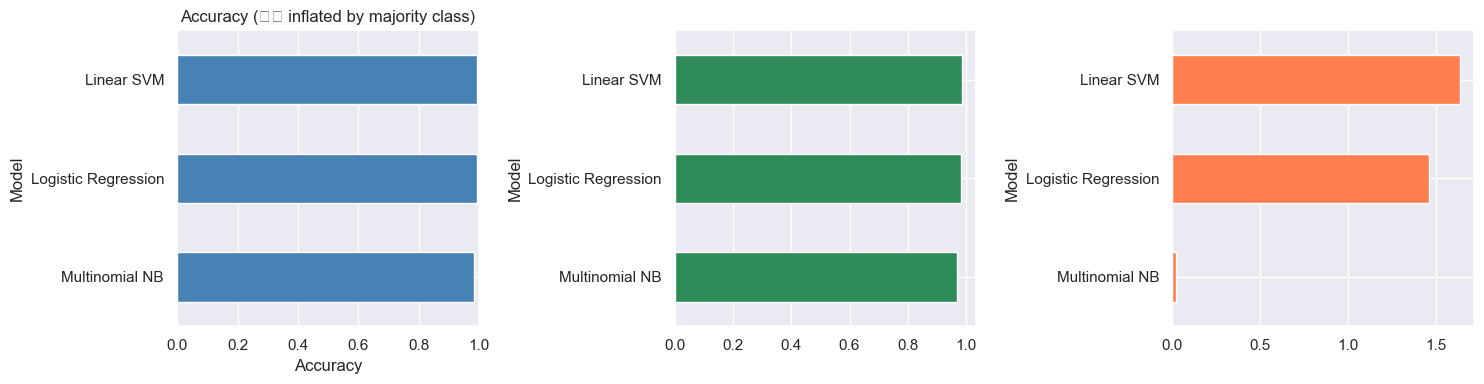

📊 For imbalanced datasets like ours, Macro F1 is more reliable than Accuracy!


In [ ]:
# 🚧 TODO: Visualize the classifier comparison results

# Solution:
# Visualize comparison - using Macro F1 (better for imbalanced data!)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Accuracy comparison (with caveat)
results_df["Accuracy"].plot(kind="barh", ax=axes[0], color="steelblue")
axes[0].set_xlabel("Accuracy")
axes[0].set_title("Accuracy (⚠️ inflated by majority class)")
axes[0].set_xlim(0, 1)

# Macro F1 comparison (fairer metric!)
results_df["Macro F1"].plot(kind="barh", ax=axes[1], color="seagreen")

# Training time comparison
results_df["Train Time (s)"].plot(kind="barh", ax=axes[2], color="coral")

plt.tight_layout()
plt.show()

print("📊 For imbalanced datasets like ours, Macro F1 is more reliable than Accuracy!")

### 💡 Classifier Comparison Insights

**Naive Bayes:**
- ✅ Fastest to train (great for large datasets)
- ✅ Works well with sparse, high-dimensional data
- ❌ Assumes features are independent (often violated)

**Logistic Regression:**
- ✅ Good balance of speed and accuracy
- ✅ Interpretable (coefficients show feature importance)
- ✅ Regularization prevents overfitting

**Linear SVM:**
- ✅ Often best accuracy on text data
- ✅ Works well in high dimensions
- ❌ Slower to train than NB
- ❌ Less interpretable

**Rule of thumb:** Start with Naive Bayes for quick experiments, use Logistic Regression for interpretability, SVM for maximum accuracy.

## Part 7: N-gram Experiments

**The Problem with Unigrams (single words):**
- "not good" → ["not", "good"] → Loses the negation!
- "machine learning" → ["machine", "learning"] → Loses the phrase meaning!

**N-grams capture word sequences:**
```
Unigrams (1):  ["the", "robot", "is", "good"]
Bigrams (2):   ["the robot", "robot is", "is good"]
Trigrams (3):  ["the robot is", "robot is good"]
```

**Trade-off:** More n-grams = more features = slower & risk of overfitting.

**🚧 TODO:** Compare unigram vs unigram+bigram features.

In [24]:
# 🚧 TODO: Compare unigrams, bigrams, and uni+bigrams
# Compare different n-gram configurations

# Solution:
ngram_configs = [
    ("Unigrams (1,1)", (1, 1)),
    ("Uni+Bigrams (1,2)", (1, 2)),
    ("Bigrams only (2,2)", (2, 2)),
]

ngram_results = []

for name, ngram_range in tqdm(ngram_configs, desc="Testing n-grams"):
    # Create vectorizer with specific n-gram range
    vec = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=ngram_range)
    X_ngram = vec.fit_transform(df["text"])
    
    # Split
    X_tr, X_te, y_tr, y_te = train_test_split(X_ngram, y, test_size=0.2, random_state=42)
    
    # Train Naive Bayes
    clf = MultinomialNB()
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    
    acc = (y_pred == y_te).mean()
    n_features = X_ngram.shape[1]
    
    ngram_results.append({
        "N-gram Config": name,
        "Accuracy": acc,
        "Num Features": n_features
    })

ngram_df = pd.DataFrame(ngram_results)
print(ngram_df.to_string(index=False))

Testing n-grams: 100%|██████████| 3/3 [01:23<00:00, 27.68s/it]

     N-gram Config  Accuracy  Num Features
    Unigrams (1,1)     0.987          5000
 Uni+Bigrams (1,2)     0.983          5000
Bigrams only (2,2)     0.904          5000


### 🔍 N-gram Results Analysis

**Surprising result:** Unigrams alone perform best (98.7%)!

| Config | Accuracy | Why? |
|--------|----------|------|
| **Unigrams** | 98.7% | Single words are enough to distinguish these categories |
| **Uni+Bigrams** | 98.3% | Slightly worse — bigrams add noise without adding signal |
| **Bigrams only** | 90.4% | Much worse — loses important single-word features |

**Why don't bigrams help here?**

1. **Categories are already easy to separate** — Single distinctive words like "robot", "wood", "myth" are sufficient. Adding "arduino uno" doesn't help when "arduino" alone is already 100% robotics.

2. **Feature budget is fixed** — With `max_features=5000`, adding bigrams means removing some unigrams. We lose "arduino" to make room for "arduino uno".

3. **Bigrams are sparser** — Each bigram appears in fewer documents, making them less reliable for classification.

**When DO bigrams help?**
- Sentiment analysis: "not good" vs "good"
- Phrase-based topics: "machine learning", "climate change"
- Disambiguation: "apple pie" vs "apple stock"

**Key insight:** More features ≠ better. Match your representation to your task!

In [25]:
# Show example bigrams from our corpus with their frequencies
bigram_vec = TfidfVectorizer(ngram_range=(2, 2), max_features=100, stop_words="english")
X_bigrams = bigram_vec.fit_transform(df["text"])

# Get bigram names and their total TF-IDF scores across all documents
bigram_names = bigram_vec.get_feature_names_out()
bigram_scores = X_bigrams.sum(axis=0).A1  # Sum TF-IDF across all docs

# Also get document frequency (how many docs contain each bigram)
doc_freq = (X_bigrams > 0).sum(axis=0).A1

# Create DataFrame and sort by frequency
bigram_df = pd.DataFrame({
    "bigram": bigram_names,
    "total_tfidf": bigram_scores,
    "doc_count": doc_freq
}).sort_values("total_tfidf", ascending=False)

print("Top 30 Bigrams in Corpus (by total TF-IDF score):")
print(bigram_df.head(30).to_string(index=False))

Top 30 Bigrams in Corpus (by total TF-IDF score):
           bigram  total_tfidf  doc_count
originally posted     9022.623      35806
       post score     9015.233      35796
  answer accepted     4514.132      35797
    original site     4511.055      35799
        site post     4508.452      35796
    answers karma     4508.071      35796
accepted original     4507.419      35795
      ros answers     4488.385      33867
 comments comment     4248.045      25327
original comments     4243.303      25327
   score original     4216.074      25057
          ros org     2350.373       9548
         don know     1797.358       4175
      launch file     1687.677       4409
         http www     1464.125       3486
       github com     1425.305       4696
       looks like     1409.988       3805
 comment gvdhoorn     1407.700       3738
          opt ros     1381.113       4598
     https github     1346.466       4395
        make sure     1323.388       3502
thanks originally     1200

## Part 8: Feature Importance

Which words are most predictive for each category? 

**How it works:**  
Logistic Regression learns a **weight (coefficient)** for each word.
- **Positive coefficient** → word predicts this category
- **Negative coefficient** → word predicts other categories

```
P(mythology | text) ∝ w_myth × count("myth") + w_god × count("god") + ...
                      ↑ high weight = important for mythology
```

**🚧 TODO:** Identify the top features for each category.

In [33]:
# 🚧 TODO: Extract and display top predictive words per category
# Train Logistic Regression to extract feature importance

# Solution:
# Using multi_class='ovr' for clearer per-class coefficients
# lr_clf = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_clf.fit(X_tfidf, y)

# Get feature names from our TF-IDF vectorizer
feature_names = tfidf_vec.get_feature_names_out()

# Show top predictive words per category
n_top = 10

print("=" * 60)
print("TOP PREDICTIVE WORDS PER CATEGORY")
print("(Higher coefficient = stronger predictor for this category)")
print("=" * 60)

for i, category in enumerate(CORPORA):
    # Each row of coef_ corresponds to one class
    coefs = lr_clf.coef_[i]
    
    # Get indices of top coefficients
    top_indices = np.argsort(coefs)[-n_top:][::-1]
    
    print(f"\n📚 {category.upper()}:")
    for idx in top_indices:
        print(f"   {feature_names[idx]:20s} (weight: {coefs[idx]:+.2f})")

TOP PREDICTIVE WORDS PER CATEGORY
(Higher coefficient = stronger predictor for this category)

📚 MYTHOLOGY:
   mythology            (weight: +4.98)
   god                  (weight: +3.81)
   gods                 (weight: +3.75)
   story                (weight: +3.36)
   myth                 (weight: +3.25)
   folklore             (weight: +3.21)
   myths                (weight: +3.18)
   ancient              (weight: +3.02)
   greek                (weight: +2.94)
   zeus                 (weight: +2.84)

📚 WOODWORKING:
   wood                 (weight: +7.02)
   saw                  (weight: +3.34)
   blade                (weight: +3.33)
   dust                 (weight: +3.01)
   finish               (weight: +2.93)
   cut                  (weight: +2.80)
   table                (weight: +2.74)
   glue                 (weight: +2.70)
   router               (weight: +2.60)
   drill                (weight: +2.55)

📚 ROBOTICS:
   ros                  (weight: +6.57)
   robot               

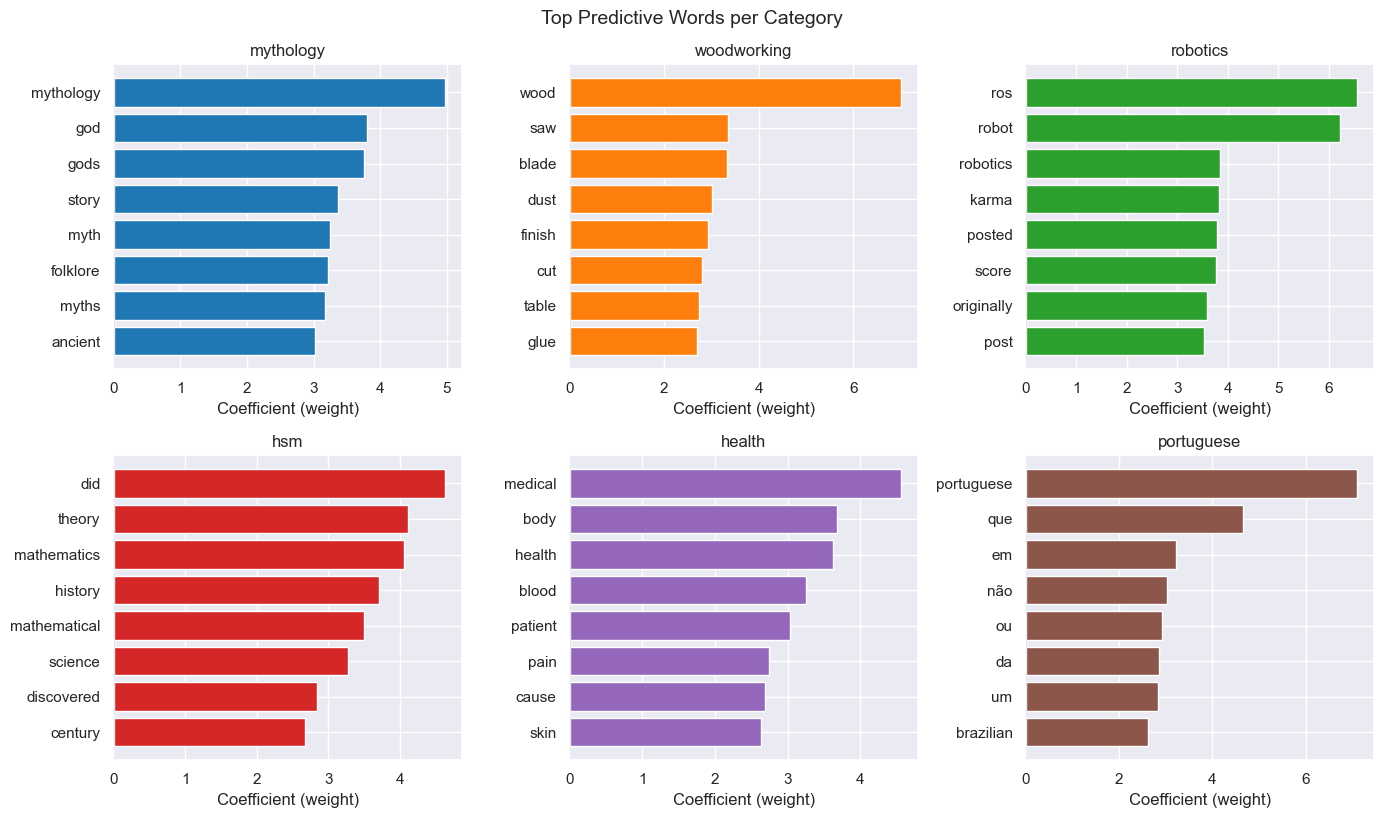

In [30]:
# 🚧 TODO: Visualize feature importance as bar charts

# Solution:
# Visualize feature importance for all 6 categories
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, category in enumerate(CORPORA):
    ax = axes[i]
    coefs = lr_clf.coef_[i]
    
    # Get top 8 features
    top_indices = np.argsort(coefs)[-8:]
    top_words = [feature_names[idx] for idx in top_indices]
    top_scores = [coefs[idx] for idx in top_indices]
    
    # Plot horizontal bars
    colors = ['green' if s > 0 else 'red' for s in top_scores]
    ax.barh(top_words, top_scores, color=plt.cm.tab10(i))
    ax.set_title(f"{category}")
    ax.set_xlabel("Coefficient (weight)")
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.suptitle("Top Predictive Words per Category", y=1.02, fontsize=14)
plt.show()

### 8.1 Word Clouds: Visualizing Category Vocabulary

Word clouds provide an intuitive visual representation of the most important words per category.
The size of each word reflects its coefficient weight (importance for prediction).

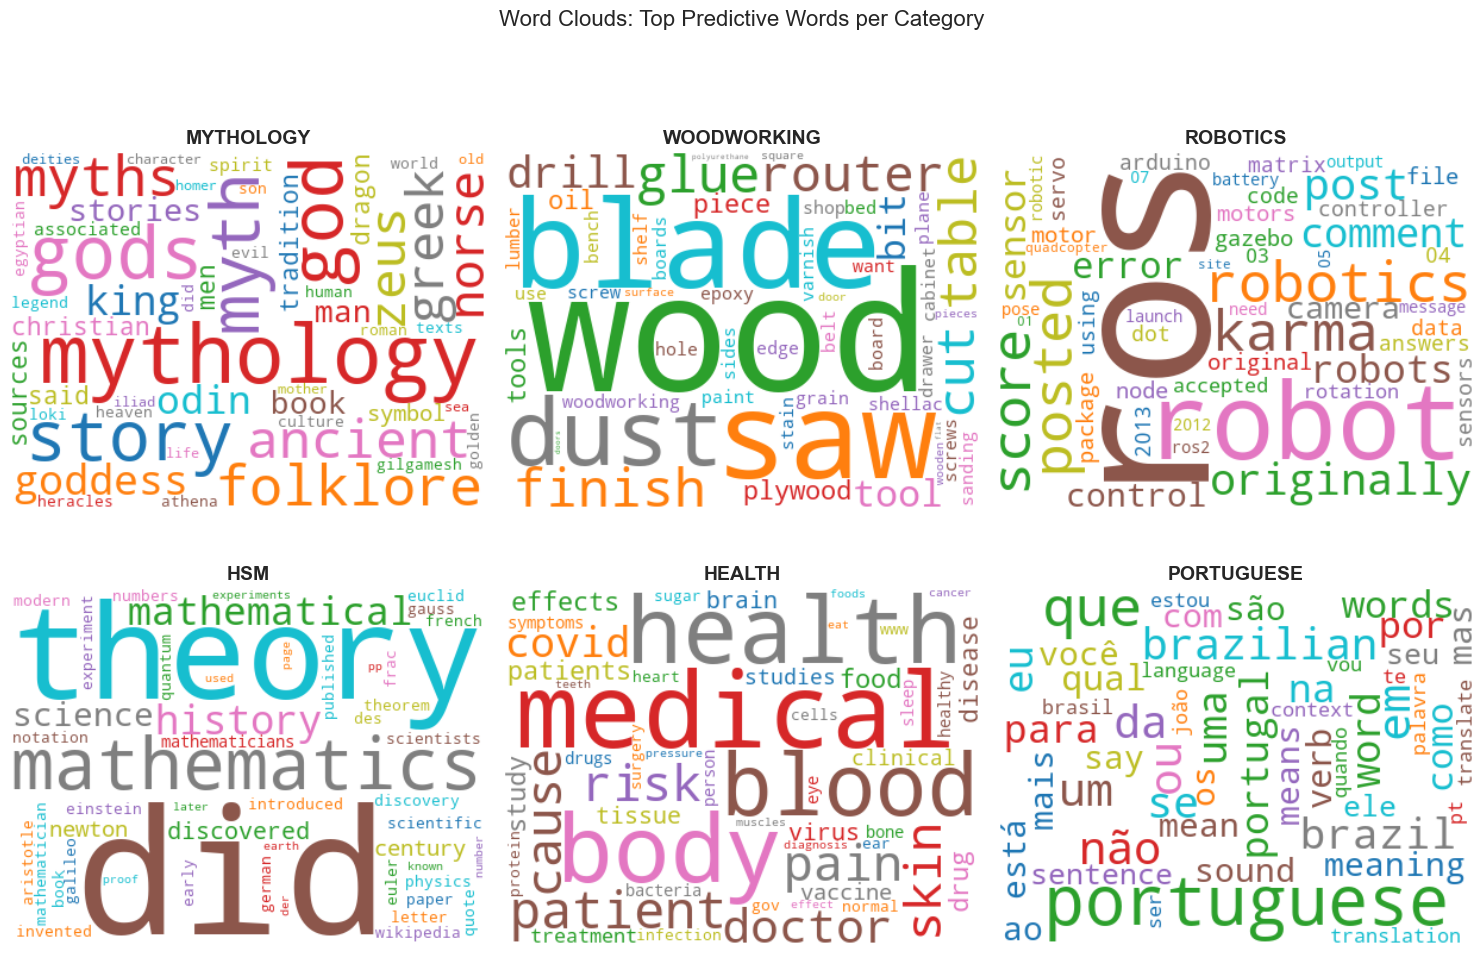

In [31]:
# Word Cloud visualization of top predictive words per category
# Using coefficient weights as word sizes

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, category in enumerate(CORPORA):
    ax = axes[i]
    coefs = lr_clf.coef_[i]
    
    # Create word->weight dictionary (only positive weights)
    word_weights = {}
    for idx, weight in enumerate(coefs):
        if weight > 0:
            word_weights[feature_names[idx]] = weight
    
    # Generate word cloud
    if word_weights:
        wc = WordCloud(
            width=400, height=300,
            background_color='white',
            colormap=f'tab10',
            max_words=50,
            prefer_horizontal=0.7
        ).generate_from_frequencies(word_weights)
        
        ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"{category.upper()}", fontsize=14, fontweight='bold')
    ax.axis('off')

plt.suptitle("Word Clouds: Top Predictive Words per Category", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Part 9: Hyperparameter Tuning

The performance of text classifiers depends heavily on vectorization parameters. Let's systematically explore:
- **`max_features`**: How many vocabulary words to keep
- **`min_df`**: Minimum document frequency (ignore rare words)

**🚧 TODO:** Experiment with different hyperparameters and observe their effect.

这一部分的作用是：**系统性地探索文本分类器在不同特征提取参数下的表现变化**，帮助你理解和优化模型。

### 详细解释

- **max_features**：指定词汇表中最多保留多少个高频词（如5000），其余的低频词会被丢弃。  
  - 作用：减少特征数量，提升计算效率，防止过拟合。
  - 太小：信息损失，模型表现下降。
  - 太大：包含噪声词，增加计算量，可能过拟合。

- **min_df**：一个词至少要在多少个文档中出现才会被保留。  
  - 作用：过滤掉极其罕见的词（如只出现一次的错别字），减少噪声。
  - 太小：保留太多稀有词，噪声大。
  - 太大：丢失有用的专业词汇。

### 为什么要实验这些参数？

- 文本特征空间极大（几千到几十万维），参数设置会极大影响模型效果和效率。
- 通过实验不同参数，观察准确率、特征数量等指标的变化，找到最优组合。

### 实验方法

- 循环不同的 `max_features` 和 `min_df`，每次都用相同的数据和分类器训练、测试，记录准确率和特征数。
- 用图表展示参数变化对模型表现的影响。

### 结论

- **调参是文本分类不可或缺的一步**，直接影响模型的泛化能力和实际应用效果。
- 通过本节实验，你能直观理解“特征数量-模型表现-计算效率”三者的权衡关系。

---

简言之：**本节让你用实验数据说话，找到适合自己任务的特征提取参数，而不是盲目用默认值。**

Testing max_features: 100%|██████████| 9/9 [01:21<00:00,  9.08s/it]


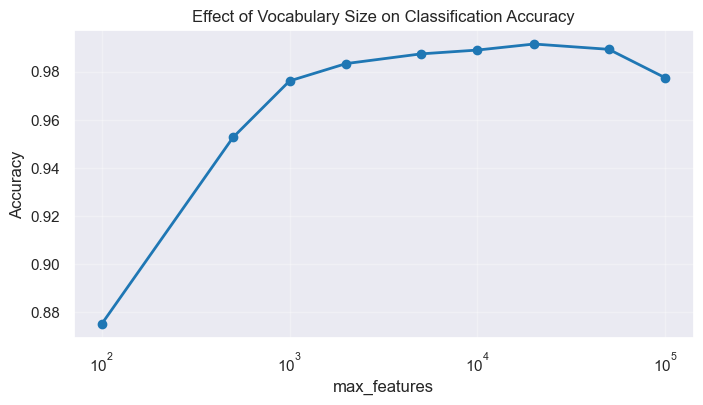

 max_features  accuracy
          100     0.875
          500     0.953
         1000     0.976
         2000     0.983
         5000     0.987
        10000     0.989
        20000     0.991
        50000     0.989
       100000     0.977


In [34]:
# 🚧 TODO: Experiment with different max_features values
# Experiment 1: Effect of max_features

# Solution:
max_features_options = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
max_feat_results = []

for max_feat in tqdm(max_features_options, desc="Testing max_features"):
    vec = TfidfVectorizer(max_features=max_feat, stop_words="english")
    X_exp = vec.fit_transform(df["text"])
    
    X_tr, X_te, y_tr, y_te = train_test_split(X_exp, y, random_state=42)
    
    clf = MultinomialNB()
    clf.fit(X_tr, y_tr)
    acc = (clf.predict(X_te) == y_te).mean()
    
    max_feat_results.append({"max_features": max_feat, "accuracy": acc})

max_feat_df = pd.DataFrame(max_feat_results)

plt.figure(figsize=(8, 4))
plt.plot(max_feat_df["max_features"], max_feat_df["accuracy"], marker="o", linewidth=2)
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.title("Effect of Vocabulary Size on Classification Accuracy")
plt.xscale("log")
plt.grid(True, alpha=0.3)
plt.show()

print(max_feat_df.to_string(index=False))

Testing min_df: 100%|██████████| 9/9 [01:22<00:00,  9.21s/it]


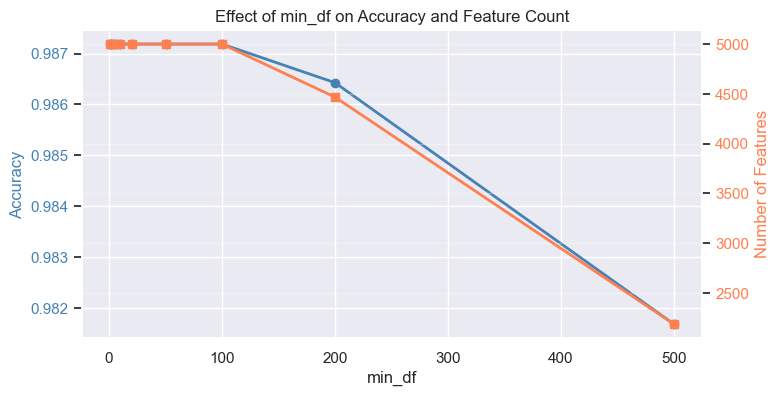

 min_df  accuracy  num_features
      1     0.987          5000
      2     0.987          5000
      5     0.987          5000
     10     0.987          5000
     20     0.987          5000
     50     0.987          5000
    100     0.987          5000
    200     0.986          4467
    500     0.982          2185


In [35]:
# Experiment 2: Effect of min_df (minimum document frequency)
# min_df filters out words that appear in fewer than N documents
# 
# ⚠️ NOTE: With max_features=5000, min_df has NO effect until it removes
# enough rare words that the vocabulary drops below 5000!
# That's why accuracy stays constant at 0.987 until min_df=200.
# 
# The lesson: max_features already removes rare words (keeps only top 5000).
# min_df becomes useful when you DON'T cap max_features, or when you want
# to explicitly filter domain-specific rare terms.

min_df_options = [1, 2, 5, 10, 20, 50, 100, 200, 500]
min_df_results = []

for min_df in tqdm(min_df_options, desc="Testing min_df"):
    vec = TfidfVectorizer(max_features=5000, min_df=min_df, stop_words="english")
    X_exp = vec.fit_transform(df["text"])
    
    X_tr, X_te, y_tr, y_te = train_test_split(X_exp, y, test_size=0.2, random_state=42)
    
    clf = MultinomialNB()
    clf.fit(X_tr, y_tr)
    acc = (clf.predict(X_te) == y_te).mean()
    n_features = X_exp.shape[1]
    
    min_df_results.append({"min_df": min_df, "accuracy": acc, "num_features": n_features})

min_df_df = pd.DataFrame(min_df_results)

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(min_df_df["min_df"], min_df_df["accuracy"], marker="o", color="steelblue", linewidth=2, label="Accuracy")
ax1.set_xlabel("min_df")
ax1.set_ylabel("Accuracy", color="steelblue")
ax1.tick_params(axis="y", labelcolor="steelblue")

ax2 = ax1.twinx()
ax2.plot(min_df_df["min_df"], min_df_df["num_features"], marker="s", color="coral", linewidth=2, label="Num Features")
ax2.set_ylabel("Number of Features", color="coral")
ax2.tick_params(axis="y", labelcolor="coral")

plt.title("Effect of min_df on Accuracy and Feature Count")
plt.grid(True, alpha=0.3)
plt.show()

print(min_df_df.to_string(index=False))

这段代码的作用是**系统性地考察 TfidfVectorizer 的 `min_df` 参数对文本分类准确率和特征数量的影响**。

---

### 代码解释

1. **min_df_options**  
   设定一组不同的 `min_df` 值（如1、2、5、10等），即一个词至少要在多少个文档中出现才会被保留。

2. **循环实验**  
   对每个 `min_df`：
   - 用 `TfidfVectorizer(max_features=5000, min_df=..., stop_words="english")` 提取特征。
   - 用 `train_test_split` 划分训练/测试集。
   - 用 `MultinomialNB()` 训练模型并计算测试集准确率。
   - 记录当前特征数量和准确率。

3. **结果可视化**  
   - 左轴画出 `min_df` 不同取值下的准确率变化（蓝色线）。
   - 右轴画出特征数量随 `min_df` 增大而减少的趋势（橙色线）。
   - 打印每组参数下的详细结果。

---

### 现象与结论

- **当 `min_df` 很小时**，特征数量接近 5000，准确率基本不变。
- **当 `min_df` 增大到一定程度**（如200），特征数量大幅下降，准确率也可能下降。
- **原因**：  
  - `max_features=5000` 已经只保留了最常见的5000个词，`min_df` 只有在进一步过滤掉更多低频词时才会影响特征数量和模型表现。
  - 如果 `min_df` 太大，会丢掉有用的专业词汇，导致模型信息不足，准确率下降。

---

### 总结

- **max_features** 和 **min_df** 都能控制特征数量，但作用机制不同。
- **实际调参建议**：  
  - 一般先用 `max_features` 控制特征上限，再用 `min_df` 过滤极低频词。
  - 观察准确率和特征数量的变化，找到合适的平衡点。

---

**一句话总结：**  
`min_df` 越大，特征越少，噪声越少，但信息也可能丢失，准确率先稳定后下降。调参时要结合实际数据和任务需求。

In [37]:
# Experiment 3: Effect of sublinear_tf (log transformation)
# sublinear_tf replaces tf with 1 + log(tf) - reduces impact of high-frequency terms
sublinear_options = [False, True]
sublinear_results = []

for sublinear in sublinear_options:
    vec = TfidfVectorizer(max_features=5000, sublinear_tf=sublinear, stop_words="english")
    X_exp = vec.fit_transform(df["text"])
    # 🚧 TODO:
    X_tr, X_te, y_tr, y_te = train_test_split(X_exp, y, random_state=42)
    
    clf = MultinomialNB()
    clf.fit(X_tr, y_tr)
    acc = (clf.predict(X_te) == y_te).mean()
    
    sublinear_results.append({"sublinear_tf": sublinear, "accuracy": acc})

print("Effect of sublinear_tf (logarithmic term frequency):")
print(pd.DataFrame(sublinear_results).to_string(index=False))
print("\nsublinear_tf=True uses: 1 + log(tf) instead of raw tf")
print("This reduces the dominance of words that appear many times in one document")

Effect of sublinear_tf (logarithmic term frequency):
 sublinear_tf  accuracy
        False     0.987
         True     0.984

sublinear_tf=True uses: 1 + log(tf) instead of raw tf
This reduces the dominance of words that appear many times in one document


### 🔍 Sublinear TF Analysis

**Result:** `sublinear_tf=True` slightly *decreases* accuracy (98.5% vs 98.7%).

**Why?** Sublinear scaling uses `1 + log(tf)` instead of raw term frequency, which:
- Dampens the impact of words that appear many times in one document
- Useful when a word appearing 10× vs 100× doesn't mean 10× more relevant

**When sublinear_tf helps:**
- Long documents where some words repeat excessively
- Reducing the influence of "bursty" words (words that cluster in specific documents)

**Why it doesn't help here:**
- Our documents are relatively short StackExchange posts
- Word repetition is already limited
- The baseline TF-IDF already works well for this corpus

**Key insight:** Sublinear scaling is a form of **dampening** — useful when raw counts are too noisy, but may lose signal when counts are already meaningful.

In [38]:
# Experiment 4: Effect of norm (L1 vs L2 normalization)
# Normalization determines how document vectors are scaled
norm_options = [None, "l1", "l2"]
norm_results = []

for norm in norm_options:
    vec = TfidfVectorizer(max_features=5000, norm=norm, stop_words="english")
    X_exp = vec.fit_transform(df["text"])
    # 🚧 TODO:
    X_tr, X_te, y_tr, y_te = train_test_split(X_exp, y, random_state=42)
    
    clf = MultinomialNB()
    clf.fit(X_tr, y_tr)
    acc = (clf.predict(X_te) == y_te).mean()
    
    # Show vector magnitude for first document
    sample_vec = X_exp[0].toarray().flatten()
    l1_norm = np.abs(sample_vec).sum()
    l2_norm = np.sqrt((sample_vec ** 2).sum())
    
    norm_results.append({"norm": str(norm), "accuracy": acc, "sample_L1": l1_norm, "sample_L2": l2_norm})

print("Effect of vector normalization:")
print(pd.DataFrame(norm_results).to_string(index=False))
print("\nL2 norm (default): ||v||₂ = 1 (unit vectors, good for cosine similarity)")
print("L1 norm: ||v||₁ = 1 (probabilities sum to 1)")
print("None: raw TF-IDF weights (longer documents have larger vectors)")

Effect of vector normalization:
norm  accuracy  sample_L1  sample_L2
None     0.981    336.887     66.755
  l1     0.782      1.000      0.198
  l2     0.987      5.047      1.000

L2 norm (default): ||v||₂ = 1 (unit vectors, good for cosine similarity)
L1 norm: ||v||₁ = 1 (probabilities sum to 1)
None: raw TF-IDF weights (longer documents have larger vectors)


### 🔍 Normalization Analysis

**Results:** L2 normalization (default) performs best, no normalization is close behind, but **L1 performs much worse!**

| Norm | Accuracy | Effect |
|------|----------|--------|
| **L2** | 98.7% | Unit vectors (‖v‖₂ = 1) |
| **None** | 98.2% | Raw TF-IDF weights |
| **L1** | 78.3% | Probabilities sum to 1 (‖v‖₁ = 1) |

**Why L1 normalization hurts Naive Bayes so badly:**
- L1 normalization forces all feature values to sum to 1, treating them like probabilities
- This **compresses** the dynamic range of TF-IDF scores dramatically (sample_L2 drops from 66.8 to 0.2!)
- Multinomial NB multiplies many small probabilities → numerical instability
- The distinctions between important and unimportant words are washed out

**Why L2 slightly beats no normalization:**
- L2 creates unit vectors, making documents comparable regardless of length
- Without normalization, longer documents have larger magnitudes, which can bias predictions

**Key insight:** For Naive Bayes with TF-IDF, use L2 normalization (the default). L1 normalization is a poor choice here because it over-compresses the feature values!

Testing C values: 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


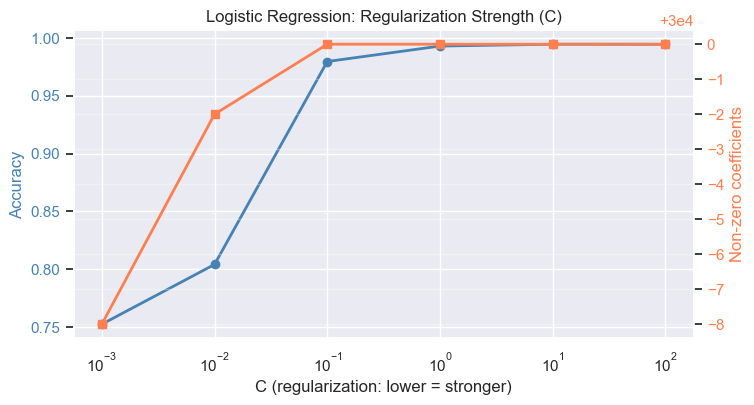

      C  accuracy  nonzero_coefs
  0.001     0.752          29992
  0.010     0.804          29998
  0.100     0.980          30000
  1.000     0.993          30000
 10.000     0.995          30000
100.000     0.995          30000

Low C = strong L2 regularization → many coefficients shrink toward 0
High C = weak regularization → model fits training data more closely


In [39]:
# Experiment 5: Classifier regularization strength (C parameter)
# For Logistic Regression: C controls regularization (smaller C = more regularization)
from sklearn.linear_model import LogisticRegression

vec = TfidfVectorizer(max_features=5000, stop_words="english")
X_exp = vec.fit_transform(df["text"])
# 🚧 TODO:
X_tr, X_te, y_tr, y_te = train_test_split(X_exp, y, random_state=42)

C_options = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
C_results = []

for C in tqdm(C_options, desc="Testing C values"):
    clf = LogisticRegression(C=C, max_iter=1000, random_state=42)
    clf.fit(X_tr, y_tr)
    acc = (clf.predict(X_te) == y_te).mean()
    
    # Count non-zero coefficients (sparsity)
    n_nonzero = (np.abs(clf.coef_) > 1e-6).sum()
    
    C_results.append({"C": C, "accuracy": acc, "nonzero_coefs": n_nonzero})

C_df = pd.DataFrame(C_results)

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.semilogx(C_df["C"], C_df["accuracy"], marker="o", color="steelblue", linewidth=2)
ax1.set_xlabel("C (regularization: lower = stronger)")
ax1.set_ylabel("Accuracy", color="steelblue")
ax1.tick_params(axis="y", labelcolor="steelblue")

ax2 = ax1.twinx()
ax2.semilogx(C_df["C"], C_df["nonzero_coefs"], marker="s", color="coral", linewidth=2)
ax2.set_ylabel("Non-zero coefficients", color="coral")
ax2.tick_params(axis="y", labelcolor="coral")

plt.title("Logistic Regression: Regularization Strength (C)")
plt.grid(True, alpha=0.3)
plt.show()

print(C_df.to_string(index=False))
print("\nLow C = strong L2 regularization → many coefficients shrink toward 0")
print("High C = weak regularization → model fits training data more closely")

### 🔍 Regularization Strength (C) Analysis

**Results:** Performance is stable across a wide range of C values, but extreme regularization (C=0.001) hurts accuracy.

| C Value | Regularization | Effect |
|---------|----------------|--------|
| **0.001** | Very strong | Underfitting — too many coefficients shrunk to zero |
| **0.01–1.0** | Moderate | Good balance — prevents overfitting |
| **10–100** | Weak | Slightly higher variance, but still works well |

**What C controls:**
- **Low C** = Strong L2 regularization → coefficients shrink toward zero → simpler model
- **High C** = Weak regularization → model fits training data more closely → risk of overfitting

**Why the "sweet spot" is broad:**
- Our dataset is large (~50K documents) relative to features (5000)
- Text classification with TF-IDF is already well-regularized by the high dimensionality
- The model has enough data to learn without needing strong regularization

**The non-zero coefficient plot shows:**
- With very low C, many coefficients are effectively zero (sparse model)
- As C increases, more features are used (denser model)

**Key insight:** For text classification, the default C=1.0 usually works well. Only tune C if you see overfitting (train >> test accuracy) or underfitting.

## Part 10: Cross-Validation for Robust Evaluation
交叉验证

**The Problem with a Single Train/Test Split:**
- Results depend on which samples ended up in test set
- With a different `random_state`, we might get different accuracy!
- We need a more reliable estimate of model performance

**Cross-Validation (CV):**
```
Fold 1: [TEST] [train] [train] [train] [train]
Fold 2: [train] [TEST] [train] [train] [train]
Fold 3: [train] [train] [TEST] [train] [train]
Fold 4: [train] [train] [train] [TEST] [train]
Fold 5: [train] [train] [train] [train] [TEST]
                    ↓
         Average scores across all folds
```

**Benefits:**
- Every sample is tested exactly once
- Get mean ± std of performance (confidence interval!)
- More reliable for model comparison

**🚧 TODO:** Implement 5-fold cross-validation to compare classifiers.

Cross-validating: 100%|██████████| 3/3 [00:09<00:00,  3.12s/it]

5-Fold Cross-Validation Results:
                     Mean Accuracy        Std    Min    Max
Model                                                      
Multinomial NB               0.986  1.354e-03  0.984  0.988
Logistic Regression          0.993  5.252e-04  0.992  0.994
Linear SVM                   0.995  7.040e-04  0.994  0.995


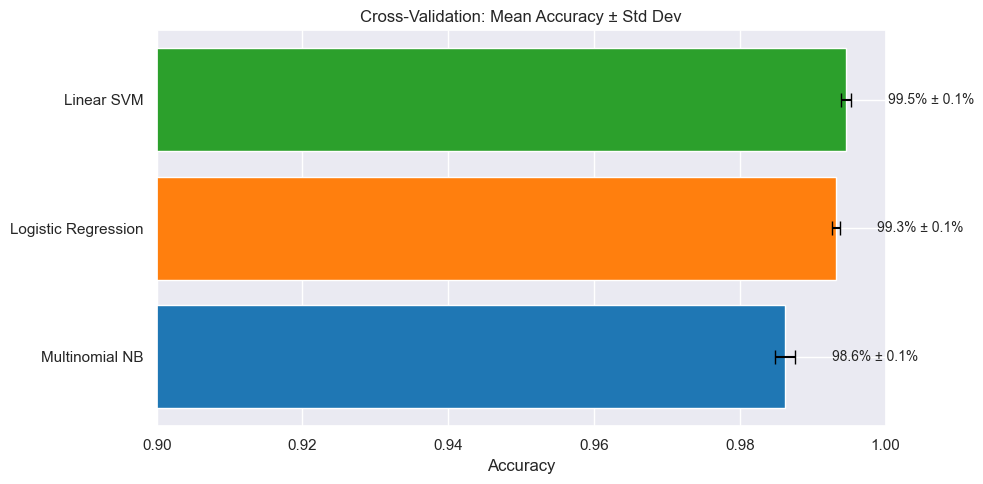

In [40]:
# 🚧 TODO: Implement cross-validation for classifier comparison
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Solution:
# Compare classifiers with 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_classifiers = [
    ("Multinomial NB", MultinomialNB()),
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("Linear SVM", LinearSVC(random_state=42, max_iter=2000)),
]

cv_results = []
for name, clf in tqdm(cv_classifiers, desc="Cross-validating"):
    scores = cross_val_score(clf, X_tfidf, y, cv=cv, scoring="accuracy", n_jobs=-1)
    cv_results.append({
        "Model": name,
        "Mean Accuracy": scores.mean(),
        "Std": scores.std(),
        "Min": scores.min(),
        "Max": scores.max(),
        "All Folds": scores
    })

cv_df = pd.DataFrame(cv_results).set_index("Model")
print("5-Fold Cross-Validation Results:")
print(cv_df[["Mean Accuracy", "Std", "Min", "Max"]].to_string())

# Visualize with error bars
fig, ax = plt.subplots(figsize=(10, 5))
means = [r["Mean Accuracy"] for r in cv_results]
stds = [r["Std"] for r in cv_results]
names = [r["Model"] for r in cv_results]

bars = ax.barh(names, means, xerr=stds, capsize=5, color=plt.cm.tab10.colors[:3])
ax.set_xlabel("Accuracy")
ax.set_title("Cross-Validation: Mean Accuracy ± Std Dev")
ax.set_xlim(0.9, 1.0)

# Add value labels
for bar, mean, std in zip(bars, means, stds):
    ax.text(mean + std + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{mean:.1%} ± {std:.1%}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### 🔍 Interpreting Cross-Validation Results

**Our Results:**

| Model | Mean Accuracy | Std Dev | Interpretation |
|-------|---------------|---------|----------------|
| **Linear SVM** | 99.5% | ±0.07% | 🥇 Best and most stable |
| **Logistic Regression** | 99.3% | ±0.05% | 🥈 Very close, lowest variance |
| **Multinomial NB** | 98.6% | ±0.14% | 🥉 Good, but slightly more variable |

**Analysis:** # 🚧 TODO:

1. **SVM ... your observations here ...** 

2. **Naive Bayes is fast but ... your observations here ...**

3. **All models have tiny ... your observations here ...** — This means ... your observations here ...

**What to look for in general:**

1. **Mean Accuracy** — The average performance across all folds. More reliable than a single split!

2. **Standard Deviation** — How much performance varies across folds. Low std = stable model.

3. **Overlapping error bars** — If error bars overlap, the difference between models may not be statistically significant.

**Key insight:** Cross-validation gives us confidence in our results. When comparing models, look at both mean AND variance!

## Summary & Key Takeaways

### 📚 What we learned:

| Topic | Key Insight |
|-------|-------------|
| **Vectorization** | Text must be converted to numbers. BoW counts words, TF-IDF weighs by importance. |
| **Sparse Matrices** | Text vectors are mostly zeros → store efficiently with sparse matrices. |
| **TF-IDF** | Downweights common words, upweights distinctive ones. Better for classification! |
| **Classifiers** | NB is fast, LogReg is interpretable, SVM often most accurate. |
| **Evaluation** | ⚠️ Use **Macro F1** for imbalanced datasets! Accuracy is inflated by majority class. |
| **N-grams** | Can capture phrases, but not always helpful. Match features to task. |
| **Feature Importance** | Model coefficients reveal which words drive predictions. |
| **Hyperparameters** | `max_features`, `min_df`, `C` all impact results significantly. |
| **Cross-Validation** | More reliable than single train/test split. Always use for model comparison! |

### 🎯 Practical Tips:

1. **Start simple** — Naive Bayes + TF-IDF is a strong baseline
2. **Inspect your data** — Class balance, text lengths, weird characters
3. **Check class balance** — With imbalanced data, prefer Macro F1 over accuracy
4. **Try multiple classifiers** — They have different strengths
5. **Use cross-validation** — Single splits can be misleading
6. **Analyze errors** — Misclassifications reveal model limitations

### 🚀 Next steps to explore:
- **Character n-grams** — Robust to typos and morphological variations
- **LSA/SVD** — Dimensionality reduction on TF-IDF (latent semantic analysis)
- **Word embeddings** — Dense representations (Word2Vec, FastText) in Notebook 3
- **Deep learning** — Neural text classifiers in later notebooks